In [3]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score

from numeric import get_numeric_df

In [4]:
original_fraud_df = pd.read_csv("..\\Dataset\\preprocessed_data\\fraud_oracle_preprocessed_drop.csv")
# Potentiall improvement - transform nominal ordered attributes to a numeric ordinal variable

def transform_fraud(original_fraud_df: pd.DataFrame) -> tuple[pd.DataFrame, np.array, PCA]:
    numeric_fraud_df = get_numeric_df(original_fraud_df)
    labels = numeric_fraud_df.FraudFound_P.to_numpy()
    numeric_unlabelled_fraud_df = numeric_fraud_df.drop("FraudFound_P", axis=1)
    normalized_fraud_df = (numeric_unlabelled_fraud_df - numeric_unlabelled_fraud_df.mean())/numeric_unlabelled_fraud_df.std()
    normalized_fraud_df = StandardScaler().fit_transform(numeric_unlabelled_fraud_df)
    pca = PCA(.95)
    pca.fit(normalized_fraud_df)
    transformed_fraud_df = pca.transform(normalized_fraud_df)
    return transformed_fraud_df, labels, pca


def train_test(classifier, train_x, train_y, test_x, test_y, verbose=False):
    classifier.fit(train_x, train_y)

    y_pred = classifier.predict(test_x)
    if verbose:
        print(confusion_matrix(y_pred, test_y))
        print(classification_report(y_pred, test_y))
    return y_pred

In [5]:
U_COEFFICIENT = 0.125
O_COEFFICIENT = 10

transformed_fraud_df, labels, pca = transform_fraud(original_fraud_df)
X_train, X_test, y_train, y_test = train_test_split(transformed_fraud_df, labels, test_size=0.2, random_state=42)

positive = X_train[y_train == 1]
negative = X_train[y_train == 0]

neg_size = int(negative.shape[0]*U_COEFFICIENT)
undersampled = np.concatenate((negative[:neg_size], positive), axis=0)
undersampled_labels = np.concatenate(
    (
        np.zeros(shape=(neg_size,), dtype=np.int64),
        np.ones(shape=(positive.shape[0],), dtype=np.int64)
    )
)

pos_size = int(positive.shape[0]*O_COEFFICIENT)
oversampled = np.concatenate((negative, np.repeat(positive, O_COEFFICIENT, axis=0)), axis=0)
oversampled_labels = np.concatenate(
    (
        np.zeros(shape=(negative.shape[0],), dtype=np.int64),
        np.ones(shape=(pos_size,), dtype=np.int64)
    )
)

## Gather data from train-test sessions over enlarged, shrunk and base training sets

In [7]:
def save_scores(predicted: np.array, actual: np.array, f1_scores: list, accuracy: list) -> None:
    f1_scores.append(f1_score(predicted, actual))
    accuracy.append(accuracy_score(predicted, actual))

under = (undersampled, undersampled_labels)
over = (oversampled, oversampled_labels)
base = (X_train, y_train)
test = (X_test, y_test)

base_f1_scores = []
under_f1_scores = []
over_f1_scores = []

base_accuracy = []
under_accuracy = []
over_accuracy = []

sizes = (2, 4, 8, 16, 32, 64, 128, 256, 512)
for hidden_layer_size in sizes:
    classifier = MLPClassifier(hidden_layer_sizes=(hidden_layer_size, ), alpha=1, max_iter=10_000, random_state=42)
    for train_set, f1, acc in zip((under, over, base), (under_f1_scores, over_f1_scores, base_f1_scores), (under_accuracy, over_accuracy, base_accuracy)):
        predicted = train_test(classifier, *train_set, *test)
        save_scores(predicted, y_test, f1, acc)


### Comparison of F1 score of the FraudFound_P = 1 class over three training sets

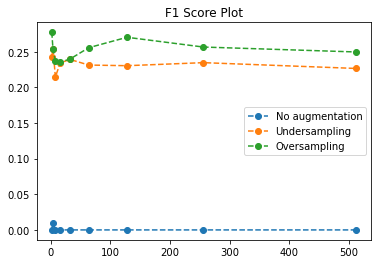

In [24]:
plt.plot(sizes, base_f1_scores, label="No augmentation", linestyle="--", marker='o')
plt.plot(sizes, under_f1_scores, label = "Undersampling", linestyle="--", marker='o')
plt.plot(sizes, over_f1_scores, label="Oversampling", linestyle="--", marker='o')
plt.title("F1 Score Plot")
plt.legend()
plt.show()

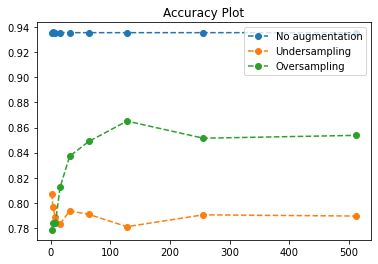

In [25]:
plt.plot(sizes, base_accuracy, label="No augmentation", linestyle="--", marker='o')
plt.plot(sizes, under_accuracy, label = "Undersampling", linestyle="--", marker='o')
plt.plot(sizes, over_accuracy, label="Oversampling", linestyle="--", marker='o')
plt.title("Accuracy Plot")
plt.legend()
plt.show()

## Data Generation

## Grid Search

In [11]:
params = [dict(
    hidden_layer_sizes=[(64,), (128,), (64, 32), (128, 64), (128, 64, 32), (128, 64, 64), (128, 64, 32, 16)],
    activation=["tanh", "relu"],
    solver=["adam"],
    learning_rate=["constant", "adaptive"],
    alpha=[0.00001, 0.0001, 0.001, 0.01, 0.1, 1]
)]

clf = MLPClassifier(max_iter=10_000)
gs = GridSearchCV(clf, param_grid=params, scoring="f1", cv=5)
gs.fit(undersampled, undersampled_labels)   

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=10000),
             param_grid=[{'activation': ['tanh', 'relu'],
                          'alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1],
                          'hidden_layer_sizes': [(64,), (128,), (64, 32),
                                                 (128, 64), (128, 64, 32),
                                                 (128, 64, 64),
                                                 (128, 64, 32, 16)],
                          'learning_rate': ['constant', 'adaptive'],
                          'solver': ['adam']}],
             scoring='f1')

In [13]:
gs.best_params_

{'activation': 'tanh',
 'alpha': 0.0001,
 'hidden_layer_sizes': (64,),
 'learning_rate': 'adaptive',
 'solver': 'adam'}

In [14]:
gs.best_score_

0.5557679576517505